In [0]:
import torch
import torchvision
import torchvision.transforms as transforms

In [0]:
device = torch.device("cuda:0" if torch.cuda.is_available() else 'cpu')
print(device)

cuda:0


In [0]:
transform = transforms.Compose([transforms.ToTensor(),
                                transforms.Normalize((0.5, 0.5, 0.5), (0.5, 0.5, 0.5))])
trainset = torchvision.datasets.CIFAR10(root='./data', train=True,download=True,transform=transform)
trainloader = torch.utils.data.DataLoader(trainset, batch_size=4, shuffle=True, num_workers=2)
testset = torchvision.datasets.CIFAR10(root='./data',train=False,download=True,transform=transform)
testloader = torch.utils.data.DataLoader(testset,batch_size=4,shuffle=False,num_workers=2)

classes = ('plane','car','bird','cat',
           'deer','dog','frog','horse','ship','truck')

Extracting ./data/cifar-10-python.tar.gz to ./data
Files already downloaded and verified


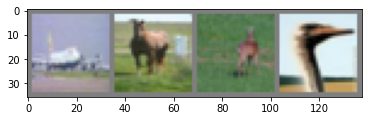

     plane      horse       deer       bird


In [0]:
import matplotlib.pyplot as plt
import numpy as np

#Function to show image
def imshow(img):
  img = img/ 2 + 0.5 #unnormalize
  npimg = img.numpy()
  plt.imshow(np.transpose(npimg,(1,2,0)))
  plt.show()

#get some random training images
dataiter = iter(trainloader)
images, labels = dataiter.next()

#show images
imshow(torchvision.utils.make_grid(images))
#print labels
print(' '.join('%10s' % classes[labels[j]] for j in range(4)))

In [0]:
import torch.nn as nn
import torch.nn.functional as F

class Net(nn.Module):
  def __init__(self):
    super(Net,self).__init__()
    self.conv1 = nn.Conv2d(3,6,5)
    self.pool = nn.MaxPool2d(2,2)
    self.conv2 = nn.Conv2d(6,16,5)
    self.fc1 = nn.Linear(16 * 5 * 5, 120)
    self.fc2 = nn.Linear(120, 84)
    self.fc3 = nn.Linear(84, 10)

  def forward(self,x):
    x = self.pool(F.relu(self.conv1(x)))
    x = self.pool(F.relu(self.conv2(x)))
    x = x.view(-1, 16 * 5 * 5)
    x = F.relu(self.fc1(x))
    x = F.relu(self.fc2(x))
    x = self.fc3(x)
    return x

net = Net()


In [0]:
import torch.optim as optim

criterion = nn.CrossEntropyLoss()
optimizer = optim.SGD(net.parameters(), lr=0.001, momentum = 0.9)
net.to(device)

Net(
  (conv1): Conv2d(3, 6, kernel_size=(5, 5), stride=(1, 1))
  (pool): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  (conv2): Conv2d(6, 16, kernel_size=(5, 5), stride=(1, 1))
  (fc1): Linear(in_features=400, out_features=120, bias=True)
  (fc2): Linear(in_features=120, out_features=84, bias=True)
  (fc3): Linear(in_features=84, out_features=10, bias=True)
)

In [0]:
for epoch in range(2):
  running_loss = 0.0
  for i, data in enumerate(trainloader,0):
    # get the inputs; data is a list of [inputs, labels]
    inputs, labels = data[0].to(device), data[1].to(device)

    #zero the parameter gradients
    optimizer.zero_grad()

    #forward + backward + optimize
    outputs = net(inputs)# forward propagation in action
    loss = criterion(outputs, labels) #Computes loss
    loss.backward() #computes dloss/dx for every parameter x which has requires_grad=True. 
    optimizer.step()# updates parametres of network

    #print statistics
    running_loss += loss.item()
    if i % 2000 == 1999: # print every 2000 mini-batches
      print('[%d,%5d] loss: %.3f' %
            (epoch + 1, i+1, running_loss/2000))
      running_loss = 0.0
print('Finished training')

[1, 2000] loss: 1.997
[1, 4000] loss: 1.768
[1, 6000] loss: 1.609
[1, 8000] loss: 1.552
[1,10000] loss: 1.493
[1,12000] loss: 1.452
[2, 2000] loss: 1.379
[2, 4000] loss: 1.377
[2, 6000] loss: 1.363
[2, 8000] loss: 1.317
[2,10000] loss: 1.310
[2,12000] loss: 1.287
Finished training


In [0]:
path = './cifar_net.pth'
torch.save(net.state_dict(),path)

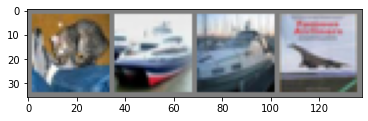

GroundTruth:      cat    ship    ship   plane


In [0]:
dataiter = iter(testloader)
images, labels = dataiter.next()

#print images
imshow(torchvision.utils.make_grid(images))
print('GroundTruth: '," ".join('%7s'% classes[labels[j]] for j in range(4)))

In [0]:
net = Net()
net.load_state_dict(torch.load(path))

<All keys matched successfully>

In [0]:
outputs = net(images)

In [0]:
_, predicted = torch.max(outputs, 1)
print('Predicted: '," ".join('%7s'% classes[labels[j]] for j in range(4)))

Predicted:      cat    ship    ship   plane


In [0]:
correct = 0
total = 0
with torch.no_grad():
  for data in testloader:
    images,labels = data
    outputs = net(images)
    _, predicted = torch.max(outputs.data,1)
    total += labels.size(0)
    correct += (predicted == labels).sum().item()
    
print('Accuracy of the network on the 10000 test images: %d %%' % (100* correct / total))